In [2]:
!pip install contractions wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 11.2 MB/s 
     |████████████████████████████████| 110 kB 22.5 MB/s 


In [ ]:
# !pip install gensim==4.2.0
# Restart Runtime after installing latest version of gensim 
import gensim

In [21]:
import numpy as np
import pandas as pd
import string
import re
import contractions
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
df = pd.read_table('https://raw.githubusercontent.com/naveenkarya/SMSSpamDetection/main/SMSSpamCollection', sep='\t', header=None, names=['label', 'sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [ ]:
# Number of data points in dataset
df.shape[0]

5572

In [ ]:
# Class distribution
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
# Min, max, average length of ham and spam SMS messages
min_sms_len = df['sms_message'].str.len().groupby(df.label).min()
max_sms_len = df['sms_message'].str.len().groupby(df.label).max()
mean_sms_len = df['sms_message'].str.len().groupby(df.label).mean()
stdev_sms_len = df['sms_message'].str.len().groupby(df.label).std()

print(f'''Minimum message length: {min_sms_len}\n
Max message length: {max_sms_len}\n
Avg message length: {mean_sms_len}\n
Standard dev message length: {stdev_sms_len}''')

Minimum message length: label
ham      2
spam    13
Name: sms_message, dtype: int64

Max message length: label
ham     910
spam    223
Name: sms_message, dtype: int64

Avg message length: label
ham      71.482487
spam    138.670683
Name: sms_message, dtype: float64

Standard dev message length: label
ham     58.440652
spam    28.873603
Name: sms_message, dtype: float64


In [ ]:
# Check if there are null values in dataset
df.isnull().sum()

label          0
sms_message    0
dtype: int64

## Data Preprocessing

In [6]:
# Assign labels as binary values to run regression (spam = 1, ham = 0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})
df.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
import contractions
stop_words = stopwords.words('english')
def preprocess_data(msg):
    # Expand contractions
    msg = contractions.fix(msg)
    # Convert to lowercase & remove punctuations
    msg = "".join([word.lower() for word in msg if word not in string.punctuation]) 
    # Remove numbers and non-alphabetical letters
    msg = re.sub('[^a-zA-Z]+', ' ', msg)
    # Remove stopwords
    tokens = [word for word in msg.split() if word not in stop_words]
    return " ".join(tokens)

df['sms_message'] = df['sms_message'].apply(lambda x: preprocess_data(x))
df.head()

,label,sms_message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor c already say
4,0,nah think goes usf lives around though


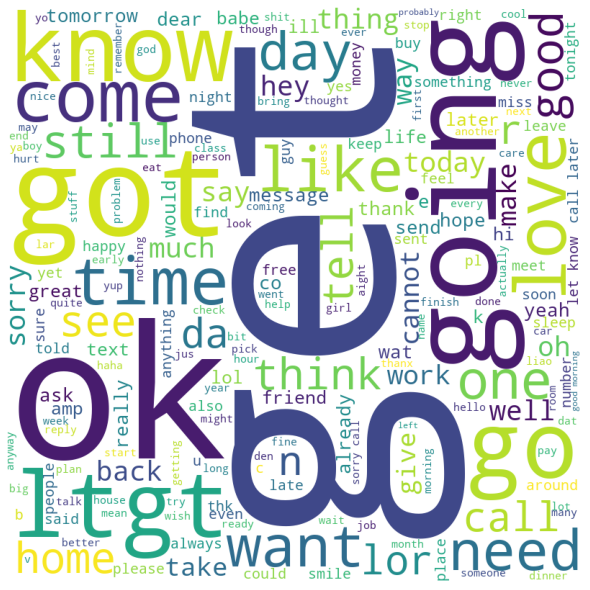

In [ ]:
# Generate ham word cloud 
text = " ".join(text for text in df[df['label'] == 0]['sms_message'])
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(text)
# plot the WordCloud                       
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

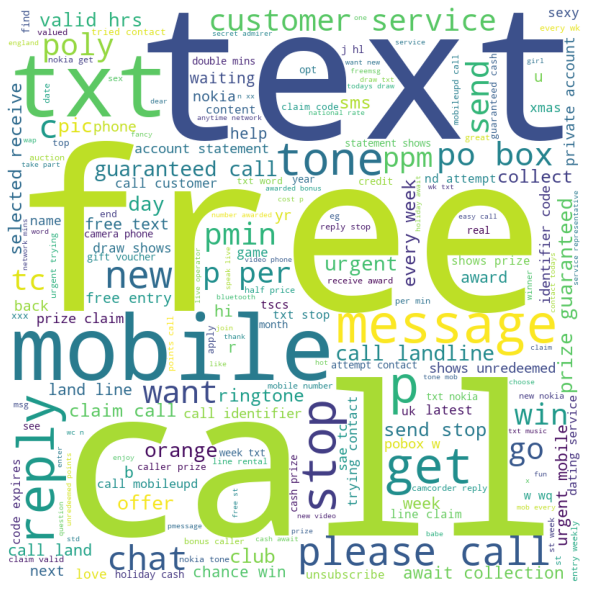

In [ ]:
# Generate spam word cloud 
text = " ".join(text for text in df[df['label'] == 1]['sms_message'])
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(text)
# plot the WordCloud                       
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
from collections import Counter
ham_counts = Counter([token for tokens in df[df['label'] == 0]['sms_message'].str.split() for token in tokens])
print(ham_counts.most_common(10))
spam_counts = Counter([token for tokens in df[df['label'] == 1]['sms_message'].str.split() for token in tokens])
print(spam_counts.most_common(10))

[('get', 309), ('ltgt', 276), ('ok', 273), ('know', 267), ('go', 253), ('got', 245), ('going', 232), ('like', 231), ('call', 231), ('come', 228)]
[('call', 362), ('free', 221), ('txt', 153), ('mobile', 125), ('text', 121), ('stop', 120), ('claim', 113), ('reply', 101), ('p', 94), ('prize', 92)]


## Train models

In [8]:
# Split dataset into 80% train / 20% test
train = df.groupby('label').sample(frac=0.8)
test = df.loc[df.index.difference(train.index)]

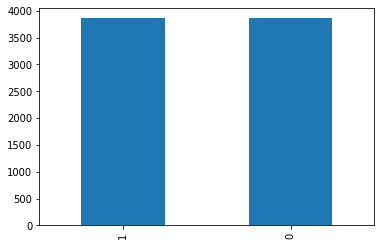

In [9]:
# Apply oversampling to fix class imbalance
ham_count, spam_count = train['label'].value_counts()
ham = train[train['label'] == 0]
spam = train[train['label'] == 1]

spam_oversampled = spam.sample(ham_count, replace=True)
train_oversampled = pd.concat([spam_oversampled, ham], axis=0)
train_oversampled.reset_index(inplace=True, drop=True)
train_oversampled['label'].value_counts().plot(kind='bar')

In [10]:
# Create feature matrix
vectorizer = TfidfVectorizer()
X_feat_mat = vectorizer.fit_transform(train_oversampled['sms_message'])
Y_Train = train_oversampled['label']

In [11]:
# Create test matrix
x_tst_mat = vectorizer.transform(test['sms_message'])

In [12]:
# Train multiple models
def train_models(models, Xtrain, Ytrain):
    for model_name, model in models.items():
        model.fit(Xtrain, Ytrain)
        

### Pick Hyperparameters

We will use 5-fold cross-validation to determine hyperparameters. We want to focus on reducing false positives (or high precision), so we will use $F_\beta-measure$ ($\beta$ = 0.5) for scoring.

In [ ]:
cross_val_feat_mat = vectorizer.fit_transform(train['sms_message'])

In [ ]:
# F-beta-scorer
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
def fbeta_scorer(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=0.5)

cust_scorer = make_scorer(fbeta_scorer, greater_is_better=True)

In [ ]:
# Pick K for KNN using cross-validation
k_to_scores = {}
k_to_scores_std = {}
for num in range(1, 70):
    knn = KNeighborsClassifier(n_neighbors=num, weights='distance')
    scores = cross_val_score(knn, cross_val_feat_mat, train['label'], cv=5, scoring=cust_scorer)
    k_to_scores[num] = np.mean(scores)
    k_to_scores_std[num] = np.std(scores)

In [ ]:
sorted(k_to_scores.items(), key = lambda x : x[1], reverse=True)[0:20]

[(53, 0.8985326582081173),
 (52, 0.8963737175021572),
 (55, 0.8959863764525883),
 (56, 0.8941240852303303),
 (61, 0.8937813623430253),
 (57, 0.8937607762788984),
 (59, 0.8935139986832213),
 (65, 0.893309455543498),
 (69, 0.8933036262954296),
 (54, 0.8932534320407332),
 (62, 0.8932289677461946),
 (58, 0.8930924324132625),
 (66, 0.8926857256775289),
 (49, 0.8924733427319577),
 (60, 0.8923906620869714),
 (68, 0.8919571049535845),
 (67, 0.8919043050893519),
 (51, 0.8916908126398209),
 (39, 0.8916777016706046),
 (41, 0.8916602224138019)]

In [ ]:
k_knn = sorted(k_to_scores.items(), key = lambda x : x[1], reverse=True)[0][0]
print(f"k = {k_knn}, std = {k_to_scores_std[k_knn]}")

k = 53, std = 0.02027627304364905


In [ ]:
# Pick regularization parameter for SVM using cross-validation
c_to_scores = {}
c_to_scores_std = {}
for num in range(1, 40, 2):
    svc = SVC(C=num, class_weight='balanced')
    scores = cross_val_score(svc, cross_val_feat_mat, train['label'], cv=5, scoring=cust_scorer)
    c_to_scores[num] = np.mean(scores)
    c_to_scores_std[num] = np.std(scores)

In [ ]:
sorted(c_to_scores.items(), key = lambda x : x[1], reverse=True)[0:20]

[(3, 0.9469518586213571),
 (5, 0.9469518586213571),
 (7, 0.9469518586213571),
 (9, 0.9469518586213571),
 (11, 0.9469518586213571),
 (13, 0.9469518586213571),
 (15, 0.9469518586213571),
 (17, 0.9469518586213571),
 (19, 0.9469518586213571),
 (21, 0.9469518586213571),
 (23, 0.9469518586213571),
 (25, 0.9469518586213571),
 (27, 0.9469518586213571),
 (29, 0.9469518586213571),
 (31, 0.9469518586213571),
 (33, 0.9469518586213571),
 (35, 0.9469518586213571),
 (37, 0.9469518586213571),
 (39, 0.9469518586213571),
 (1, 0.9395464694166847)]

In [ ]:
c_svm = sorted(c_to_scores.items(), key = lambda x : x[1], reverse=True)[0][0]
print(f"C for SVM = {c_svm}, std = {c_to_scores_std[c_svm]}")

C for SVM = 3, std = 0.020905866640137778


In [ ]:
# Pick regularization parameter for Logistic Regression using cross-validation
c_lr_to_scores = {}
c_lr_to_scores_std = {}
for num in range(1, 40, 2):
    lgr = LogisticRegression(C=num, class_weight='balanced')
    scores = cross_val_score(lgr, cross_val_feat_mat, train['label'], cv=5, scoring=cust_scorer)
    c_lr_to_scores[num] = np.mean(scores)
    c_lr_to_scores_std[num] = np.std(scores)

In [ ]:
sorted(c_lr_to_scores.items(), key = lambda x : x[1], reverse=True)

[(39, 0.9395208930345526),
 (25, 0.9386092847412805),
 (27, 0.9386092847412805),
 (29, 0.9386092847412805),
 (31, 0.9386092847412805),
 (33, 0.9386092847412805),
 (35, 0.9381853381842404),
 (37, 0.9381853381842404),
 (23, 0.9372866583832267),
 (21, 0.9346656887078482),
 (19, 0.9333786874208467),
 (15, 0.932108961318906),
 (17, 0.932108961318906),
 (13, 0.9321078662989143),
 (9, 0.9307746272350098),
 (11, 0.9307746272350098),
 (7, 0.9281116103802276),
 (5, 0.9275897617567296),
 (3, 0.9244392053497383),
 (1, 0.8951539330440683)]

In [ ]:
c_logr = sorted(c_lr_to_scores.items(), key = lambda x : x[1], reverse=True)[0][0]
print(f"C for LogR = {c_logr}, std = {c_lr_to_scores_std[c_logr]}")

C for LogR = 39, std = 0.022578829545670417


In [ ]:
# Pick n_estimators for Random Forest
n_to_scores = {}
n_to_scores_std = {}
for num in range(10, 200, 10):
    rf = RandomForestClassifier(n_estimators=num, class_weight='balanced')
    scores = cross_val_score(rf, cross_val_feat_mat, train['label'], cv=5, scoring=cust_scorer)
    n_to_scores[num] = np.mean(scores)
    n_to_scores_std[num] = np.std(scores)

In [ ]:
sorted(n_to_scores.items(), key = lambda x : x[1], reverse=True)

[(120, 0.956159852758993),
 (140, 0.9537091101067098),
 (70, 0.9531228585387161),
 (90, 0.9525531198535674),
 (170, 0.9524328501556824),
 (160, 0.9518485167074016),
 (190, 0.9517296012616372),
 (60, 0.9517128568980725),
 (150, 0.9515907003832481),
 (180, 0.9515390082888615),
 (80, 0.9502053000205478),
 (130, 0.9501213131093514),
 (110, 0.9496880432724634),
 (100, 0.9482856464047013),
 (40, 0.9479596272967813),
 (50, 0.9479169021909088),
 (30, 0.9444388296349965),
 (20, 0.9436980779189913),
 (10, 0.9349637565059771)]

In [ ]:
n_estimators = sorted(n_to_scores.items(), key = lambda x : x[1], reverse=True)[0][0]
print(f"Random Forest: n_estimators = {n_estimators}, std = {n_to_scores_std[n_estimators]}")

Random Forest: n_estimators = 120, std = 0.008424387651623778


In [ ]:
# Pick max_features for Random Forest
n_feat_to_scores = {}
n_feat_to_scores_std = {}
# Default value for max features is square root of number of features
base_num_feat = int(np.sqrt(cross_val_feat_mat.shape[1]))
print(f"Default value for max_features: {base_num_feat}")
# Check +-20 values before and after the default value
for num in range(base_num_feat - 20, base_num_feat + 20, 2):
    rf = RandomForestClassifier(max_features=num, class_weight='balanced')
    scores = cross_val_score(rf, cross_val_feat_mat, train['label'], cv=5, scoring=cust_scorer)
    n_feat_to_scores[num] = np.mean(scores)
    n_feat_to_scores_std[num] = np.std(scores)

Default value for max_features: 85


In [ ]:
sorted(n_feat_to_scores.items(), key = lambda x : x[1], reverse=True)

[(91, 0.956790244274891),
 (85, 0.955349880432361),
 (93, 0.9552949849375162),
 (95, 0.953976133415166),
 (89, 0.9536425991437285),
 (99, 0.9535753109793464),
 (101, 0.9535701823752323),
 (71, 0.9528235514782315),
 (83, 0.9523364020749987),
 (103, 0.951652189567193),
 (81, 0.9508179417211451),
 (87, 0.9507205844399265),
 (97, 0.9506941294838078),
 (79, 0.9502288885618997),
 (65, 0.9497180111977149),
 (67, 0.9488248624620634),
 (69, 0.9484168852042822),
 (73, 0.948383192487627),
 (75, 0.9477198736121455),
 (77, 0.9471952728720339)]

In [ ]:
max_features = sorted(n_feat_to_scores.items(), key = lambda x : x[1], reverse=True)[0][0]
print(f"Random Forest: max_features = {max_features}, std = {n_feat_to_scores_std[max_features]}")

Random Forest: max_features = 91, std = 0.012585248768621844


### Initialize and train models

In [13]:
# Initialize models
logr = LogisticRegression(C=39)
knn = KNeighborsClassifier(65, weights='distance')
mnb = MultinomialNB()
svm = SVC(C=3, probability=True)
rf = RandomForestClassifier(n_estimators=120, max_features=91)

stk = StackingClassifier(estimators=[('logr', logr),
                                     ('65knn', knn),
                                     ('mnb', mnb),
                                     ('svm', svm),
                                     ('rf', rf)])

models = {"LogisticRegression": logr, "65-KNN": knn, "Naive-Bayes": mnb, "SVM": svm, "RandomForest": rf, "Stacking": stk}

In [14]:
# Train models
train_models(models, X_feat_mat, Y_Train)

## Predict

In [15]:
def predict(models, Xtest):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(Xtest)
    return predictions

In [16]:
predictions = predict(models, x_tst_mat)

## Analyze model performance

In [17]:
# Create confusion matrix and calculate performance metrics
def evaluate_pred(actual, prediction):
    mat = metrics.confusion_matrix(actual, prediction)
    tn,fp = mat[0]
    fn,tp = mat[1]
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    return {"TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn,
            "Accuracy": (tp + tn)/(tp + fp + tn + fn), 
            "Precision": precision,
            "Recall": recall,
            "F-Measure": (2 * precision * recall)/(precision + recall),
            "conf-mat": mat}


def evaluate_models(actual, predictions):
    results = {}
    for model_name, prediction in predictions.items():
        results[model_name] = evaluate_pred(actual, prediction)
    return results

In [ ]:
results = evaluate_models(test['label'], predictions)

In [ ]:
res_df = pd.DataFrame(results)
res_df_t = res_df[~res_df.index.isin(['conf-mat'])].T
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,134,3,15,962,0.983842,0.978102,0.899329,0.937063
65-KNN,135,34,14,931,0.956912,0.798817,0.90604,0.849057
Naive-Bayes,138,31,11,934,0.962298,0.816568,0.926174,0.867925
SVM,120,0,29,965,0.973968,1.0,0.805369,0.892193
RandomForest,121,0,28,965,0.974865,1.0,0.812081,0.896296
Stacking,122,0,27,965,0.975763,1.0,0.818792,0.900369


### Experiment (Gradient boost and AdaBoost)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# train
boost_models = {"GradientBoost": GradientBoostingClassifier(), "AdaBoost": AdaBoostClassifier()}
train_models(boost_models, X_feat_mat, Y_Train)
# predict
boost_predictions = predict(boost_models, x_tst_mat)
# evaluate
boost_results = evaluate_models(test['label'], boost_predictions)
# print
res_df_extra = pd.DataFrame(boost_results)
res_df_extra_t = res_df_extra[~res_df.index.isin(['conf-mat'])].T
res_df_extra_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
GradientBoost,122,50,27,915,0.93088,0.709302,0.818792,0.760125
AdaBoost,121,30,28,935,0.947935,0.801325,0.812081,0.806667


Both the above models have low accuracy, precision and recall when compared to other models.

### Experiment - Improve recall while keeping precision high using probability threshold

In [22]:
# Use Cross validation and get precision and recall for different thresholds
threshs = np.linspace(0, 0.6, 31)
skf = StratifiedKFold(n_splits=4)
thresh_precis_scores = []
thresh_recall_scores = []
for train_index, test_index in skf.split(train, train['label']):
  precis_thresh_map = {}
  recall_thresh_map = {}
  train_tmp = train.iloc[train_index,:]
  test_tmp = train.iloc[test_index,:]
  clf = StackingClassifier(estimators=[('logr', logr),
                                     ('65knn', knn),
                                     ('mnb', mnb),
                                     ('svm', svm),
                                     ('rf', rf)])
  clf.fit(vectorizer.fit_transform(train_tmp['sms_message']), train_tmp['label'])
  test_mat_temp = vectorizer.transform(test_tmp['sms_message'])
  clf_probs = clf.predict_proba(test_mat_temp)[:,1]
  for thresh in threshs:
    recall_thresh_map[thresh] = recall_score(test_tmp['label'], [int(prob > thresh) for prob in clf_probs])
    precis_thresh_map[thresh] = precision_score(test_tmp['label'], [int(prob > thresh) for prob in clf_probs])
  thresh_recall_scores.append(recall_thresh_map)
  thresh_precis_scores.append(precis_thresh_map)

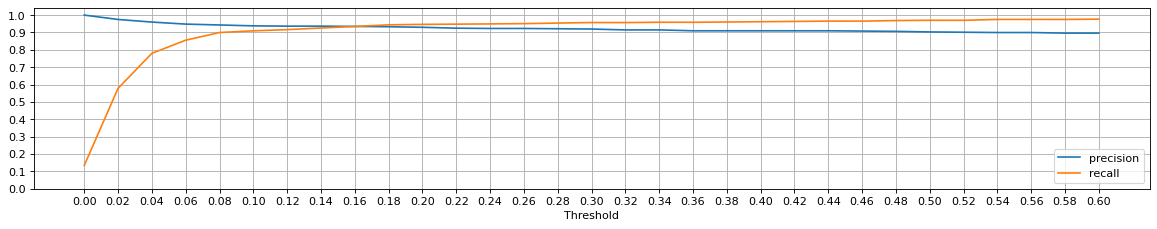

In [23]:
# Plot precision and recall for different thresholds
from matplotlib.pyplot import figure

figure(figsize=(18, 3), dpi=80)
avg_recall_scores = []
avg_precision_scores = []

for thresh in threshs:
  avg_recall_scores.append(np.mean([rec[thresh] for rec in thresh_recall_scores]))
  avg_precision_scores.append(np.mean([precis[thresh] for precis in thresh_precis_scores]))

plt.plot(threshs, avg_recall_scores, label = 'precision')
plt.plot(threshs, avg_precision_scores, label = 'recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.xticks(threshs)
plt.yticks(np.linspace(0, 1, 11))
plt.show()

From the above chart, we can choose threshold = 0.12

In [ ]:
# Use the threshold
clf = StackingClassifier(estimators=[('logr', logr),
                                     ('65knn', knn),
                                     ('mnb', mnb),
                                     ('svm', svm),
                                     ('rf', rf)])
clf.fit(X_feat_mat, Y_Train)
clf_prediction_prob = clf.predict_proba(x_tst_mat)
clf_prediction = [int(prob > 0.12) for prob in clf_prediction_prob[:,1]]
res_df_t.loc['Stacking_thresh_0.12'] = evaluate_pred(test['label'], clf_prediction)
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,134,3,15,962,0.983842,0.978102,0.899329,0.937063
65-KNN,135,34,14,931,0.956912,0.798817,0.90604,0.849057
Naive-Bayes,138,31,11,934,0.962298,0.816568,0.926174,0.867925
SVM,120,0,29,965,0.973968,1.0,0.805369,0.892193
RandomForest,121,0,28,965,0.974865,1.0,0.812081,0.896296
Stacking,122,0,27,965,0.975763,1.0,0.818792,0.900369
Stacking_thresh_0.12,131,0,18,965,0.983842,1.0,0.879195,0.935714


## Word2Vec
LSTM

In [ ]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords   
from nltk.stem.porter import PorterStemmer  
import re
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer    
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

In [ ]:
xtrain = train_oversampled['sms_message']
xtest = test['sms_message']
ytrain = train_oversampled['label']
ytest = test['label']

In [ ]:
train_oversampled['tokens'] = xtrain.apply(lambda x: gensim.utils.simple_preprocess(x))
train_oversampled[train_oversampled['label'] == 0].head()

,label,sms_message,tokens
3860,0,great trip india bring light everyone project ...,"[great, trip, india, bring, light, everyone, p..."
3861,0,ok prob,"[ok, prob]"
3862,0,sorry bathroom sup,"[sorry, bathroom, sup]"
3863,0,ebay might less elsewhere,"[ebay, might, less, elsewhere]"
3864,0,late tellmiss way,"[late, tellmiss, way]"


In [ ]:
w2v_model = gensim.models.Word2Vec(vector_size=300, 
                                            window=3, 
                                            min_count=5, 
                                            workers=8)

w2v_model.build_vocab(train_oversampled['tokens'])
words = set(w2v_model.wv.index_to_key )
w2v_model.train(train_oversampled['tokens'],total_examples=len(train_oversampled['tokens']),epochs=32)

(2144095, 2616384)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(xtrain)
vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(xtest), maxlen=300)

In [ ]:
# Build Embedding Layer
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    
from keras.layers import Activation, Dense, Dropout, Embedding
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [ ]:
# Build The model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2236200   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,329,705
Trainable params: 93,505
Non-trainable params: 2,236,200
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
history = model.fit(x_train, train_oversampled['label'],
                    batch_size=32,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
218/218 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9623

218/218 [==============================] - 276s 1s/step - loss: 0.1097 - accuracy: 0.9623 - val_loss: 0.1129 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 2/8
218/218 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9833

218/218 [==============================] - 232s 1s/step - loss: 0.0505 - accuracy: 0.9833 - val_loss: 0.0252 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 3/8
218/218 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9888

218/218 [==============================] - 232s 1s/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0214 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 4/8
218/218 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9929

218/218 [==============================] - 228s 1s/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 0.0638 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 5/8
218/218 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9947

218/218 [==============================] - 228s 1s/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 0.0376 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 6/8
218/218 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9942

218/218 [==============================] - 229s 1s/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.0195 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 7/8
218/218 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9947

218/218 [==============================] - 228s 1s/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.0296 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 8/8
218/218 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9971

218/218 [==============================] - 227s 1s/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0494 - val_accuracy: 0.9858 - lr: 0.0010


In [ ]:
y_pred = model.predict(x_test)
y_pred = (y_pred>0.5)

35/35 [==============================] - 3s 96ms/step


In [ ]:
res_df_t.loc['Word2Vec : LSTM'] = evaluate_pred(ytest,y_pred)
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,136,5,13,960,0.983842,0.964539,0.912752,0.937931
51-KNN,134,67,15,898,0.926391,0.666667,0.899329,0.765714
Naive-Bayes,138,24,11,941,0.968582,0.851852,0.926174,0.88746
SVM,129,0,20,965,0.982047,1.0,0.865772,0.928058
RandomForest,122,0,27,965,0.975763,1.0,0.818792,0.900369
Stacking,128,0,21,965,0.981149,1.0,0.85906,0.924188
Word2Vec : LSTM,143,20,6,945,0.976661,0.877301,0.959732,0.916667
Word2Vec : Random Forest,98,13,51,952,0.942549,0.882883,0.657718,0.753846


Random Forest

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

In [ ]:
w2v_model1 = gensim.models.Word2Vec(xtrain,vector_size=100,window=5,min_count=2)
words = set(w2v_model1.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model1.wv[i] for i in ls if i in words])
                         for ls in xtrain])
X_test_vect = np.array([np.array([w2v_model1.wv[i] for i in ls if i in words])
                         for ls in xtest])

<ipython-input-27-8e9b61e3ccfe>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model1.wv[i] for i in ls if i in words])
<ipython-input-27-8e9b61e3ccfe>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model1.wv[i] for i in ls if i in words])


In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
# Random Forest 
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, ytrain.values.ravel())

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)
y_pred = (y_pred>0.5)

In [ ]:
res_df_t.loc['Word2Vec : Random Forest'] = evaluate_pred(ytest,y_pred)
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,136,5,13,960,0.983842,0.964539,0.912752,0.937931
51-KNN,134,67,15,898,0.926391,0.666667,0.899329,0.765714
Naive-Bayes,138,24,11,941,0.968582,0.851852,0.926174,0.88746
SVM,129,0,20,965,0.982047,1.0,0.865772,0.928058
RandomForest,122,0,27,965,0.975763,1.0,0.818792,0.900369
Stacking,128,0,21,965,0.981149,1.0,0.85906,0.924188
Word2Vec : LSTM,143,20,6,945,0.976661,0.877301,0.959732,0.916667
Word2Vec : Random Forest,97,14,52,951,0.940754,0.873874,0.651007,0.746154


Logistic Regression 

In [ ]:
logr = LogisticRegression(C=39)
logr_model = logr.fit(X_train_vect_avg, ytrain.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
y_pred = logr_model.predict(X_test_vect_avg)
y_pred = (y_pred>0.5)

In [ ]:
res_df_t.loc['Word2Vec : LogRegression'] = evaluate_pred(ytest,y_pred)
res_df_t

,TP,FP,FN,TN,Accuracy,Precision,Recall,F-Measure
LogisticRegression,136,5,13,960,0.983842,0.964539,0.912752,0.937931
51-KNN,134,67,15,898,0.926391,0.666667,0.899329,0.765714
Naive-Bayes,138,24,11,941,0.968582,0.851852,0.926174,0.88746
SVM,129,0,20,965,0.982047,1.0,0.865772,0.928058
RandomForest,122,0,27,965,0.975763,1.0,0.818792,0.900369
Stacking,128,0,21,965,0.981149,1.0,0.85906,0.924188
Word2Vec : LSTM,143,20,6,945,0.976661,0.877301,0.959732,0.916667
Word2Vec : Random Forest,97,14,52,951,0.940754,0.873874,0.651007,0.746154
Word2Vec : LogRegression,118,191,31,774,0.800718,0.381877,0.791946,0.515284
